In [1]:
pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams, trigrams
from nltk import WordNetLemmatizer
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM, GRU
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [4]:
zomato = pd.read_csv("/content/drive/MyDrive/Projects/Zomato/zomato.csv", na_values = ["-", ""])
# Making a copy of the data to work on
data = zomato.copy()

In [5]:
# Dropping duplicates - see Part One for explanation

grouped = data.groupby(["name", "address"]).agg({"listed_in(type)" : list})
newdata = pd.merge(grouped, data, on = (["name", "address"]))
newdata["listed_in(type)_x"] = newdata["listed_in(type)_x"].astype(str) # converting unhashable list to a hashable type
newdata.drop_duplicates(subset = ["name", "address", "listed_in(type)_x"], inplace = True)
newdata = newdata.reset_index(drop = True)

In [6]:
# Transforming the ratings column 

newdata["rating"] = newdata["rate"].str[:3] # Extracting the first three characters of each string in "rate"
# Removing rows with "NEW" in ratings as it is not a predictable level
newdata = newdata[newdata.rating != "NEW"] 
# Dropping rows that have missing values in ratings 
newdata = newdata.dropna(subset = ["rating"])
# Converting ratings to a numeric column so we can discretize it
newdata["rating"] = pd.to_numeric(newdata["rating"])
# Discretizing the ratings into a categorical feature with 4 levels

newdata["rating"] = pd.cut(newdata["rating"], bins = [0, 3.0, 3.5, 4.0, 5.0], labels = ["0", "1", "2", "3"])

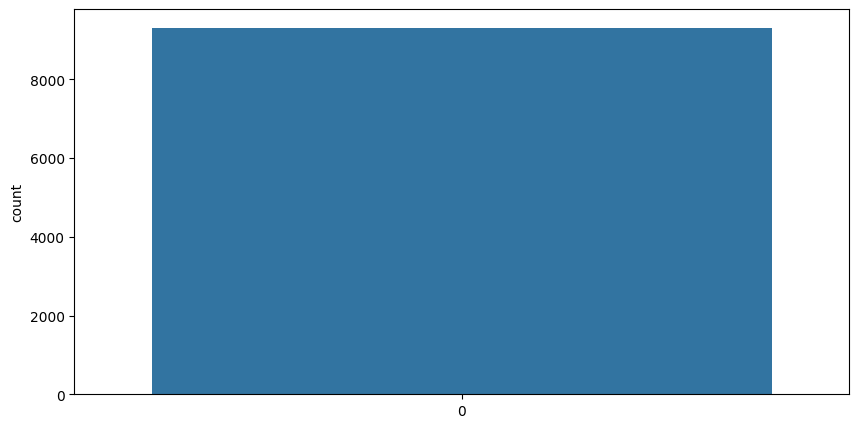

In [7]:
# Visualizing the rating class distribution
plt.figure(figsize = (10, 5))
sns.countplot(newdata["rating"])
plt.show()

In [8]:
# Summary statistics
newdata.describe(include = "all")

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
count,9316,9316,9316,9316,9316,9316,9316,9316.000000,9149,9316,9279,4577,9313,9284,9316,9316,9316,9316,9316
unique,6512,8676,870,9316,2,2,59,NaN,8381,92,86,4249,2246,63,8964,1990,7,30,4
top,Cafe Coffee Day,Delivery Only,"['Delivery', 'Dine-out']",https://www.zomato.com/bangalore/feeltheroll-b...,Yes,No,3.7/5,NaN,080 43334321,Whitefield,Quick Bites,Biryani,North Indian,400,[],[],Delivery,BTM,2
freq,49,21,872,1,5705,8393,706,NaN,55,617,3445,47,484,1370,332,7314,6519,1115,4037
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.149420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673.984948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Creating a new dataset that has only customer reviews and restaurant ratings
reviews_data = newdata[["reviews_list", "rating"]]
# Examining the reviews for the first restaurant in the dataset
reviews_data["reviews_list"][0]
# The text needs cleaning up

'[(\'Rated 5.0\', "RATED\\n  Had an egg chicken roll and a paneer roll... Really yummy... A must visit place... It would be good if you guys can keep the shop open on Sunday\'s as well.. Good luck... :-)"), (\'Rated 5.0\', \'RATED\\n  Not just the Roll but the filling tastes great. I would highly recommend to others to try their rolls. Owners hospitality is also good and very friendly.\'), (\'Rated 4.5\', \'RATED\\n  Very nice place complete value for money ? Highly recommend.Must visit for any foodie . I would recommend the egg chicken roll . #feeltheroll\'), (\'Rated 5.0\', \'RATED\\n  Had an amazing mouth-watering ?chicken roll?Worth every bite..A must try for every foodie?A variety of rolls and sandwiches are available as well .. A budding rafflesia ?\')]'

In [10]:
# Converting all the text to lowercase
reviews_data["reviews_list"] = reviews_data["reviews_list"].apply(lambda x: x.lower())

# Creating a regular expression tokenizer that matches only alphabets
# This will return separate words (tokens) from the text
tokenizer = regextoken("[a-zA-Z]+") 
# Applying the tokenizer to each row of the reviews
review_tokens = reviews_data["reviews_list"].apply(tokenizer.tokenize)
# Examining the tokens created for the first row / restaurant
print(review_tokens[0])

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [11]:
# Importing and examining the English stopwords directory 
# These are common words that typically don't add meaning to the text and can be removed
stop = stopwords.words("english")
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
# Adding custom words to stopwords 
stop.extend(["rated", "n", "nan", "x"])
# Removing stopwords from the tokens
review_tokens = review_tokens.apply(lambda x: [token for token in x if token not in stop])
# Concatenating all the reviews 
all_reviews = review_tokens.astype(str).str.cat()
cleaned_reviews = tokenizer.tokenize(all_reviews)

# Getting the frequency distribution of individual words in the reviews
fd = FreqDist()
for word in cleaned_reviews:
    fd[word] += 1
    
# Examining the top 5 most frequent words
fd.most_common(5)

[('good', 150929),
 ('food', 147551),
 ('place', 139169),
 ('chicken', 68678),
 ('ordered', 50928)]

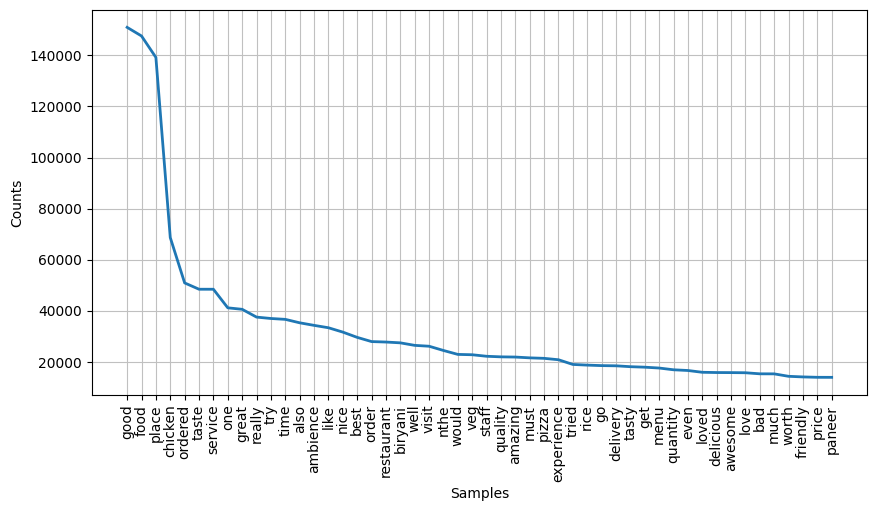

In [13]:
# Plotting the top 50 most frequent words
plt.figure(figsize = (10, 5))
fd.plot(50)
plt.show()

In [14]:
# Generating bigrams from the reviews
bigrams = bigrams(cleaned_reviews)
# Getting the bigram frequency distribution
fd_bigrams = FreqDist()
for bigram in bigrams:
    fd_bigrams[bigram] += 1
# Examining the top 5 most frequent bigrams
fd_bigrams.most_common(5)

[(('must', 'try'), 10719),
 (('really', 'good'), 9973),
 (('good', 'food'), 9939),
 (('food', 'good'), 9585),
 (('good', 'place'), 7871)]

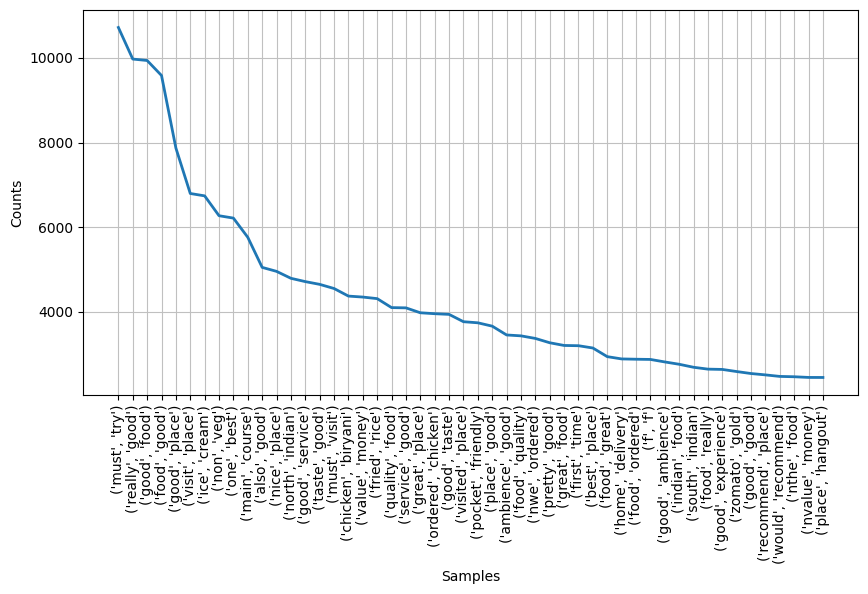

In [15]:
# Plotting the top 50 most frequent bigrams
plt.figure(figsize = (10, 5))
fd_bigrams.plot(50)
plt.show()

In [16]:
# Generating trigrams from the reviews
trigrams = trigrams(cleaned_reviews)

fd_trigrams = FreqDist()
for trigram in trigrams:
    fd_trigrams[trigram] += 1

fd_trigrams.most_common(5)

[(('xa', 'xa', 'xa'), 1975),
 (('north', 'indian', 'food'), 1707),
 (('f', 'f', 'f'), 1681),
 (('must', 'visit', 'place'), 1666),
 (('veg', 'non', 'veg'), 1634)]

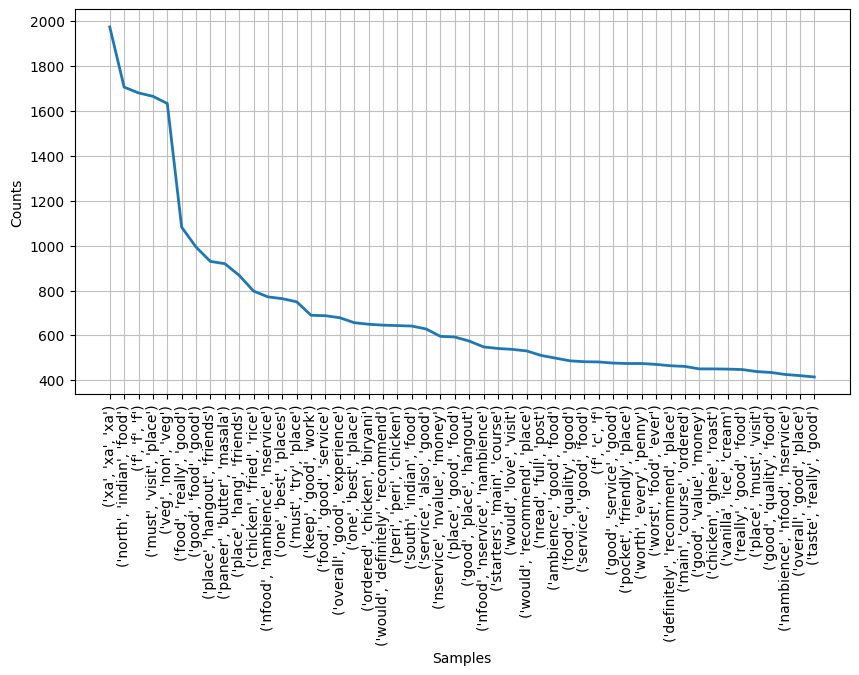

In [17]:
plt.figure(figsize = (10, 5))
fd_trigrams.plot(50)
plt.show()

In [18]:
# Creating a new dataset with cuisines info and restaurant ratings
cuisines = newdata[["cuisines", "rating"]]
cuisines["cuisines"] = cuisines["cuisines"].astype(str)
# Converting to lowercase
cuisines["cuisines"] = cuisines["cuisines"].apply(lambda x: x.lower())
# Tokenizing the cuisines
cuisine_tokens = cuisines["cuisines"].apply(tokenizer.tokenize)
# Concatenating all the cuisine names into one text document
all_cuisines = cuisine_tokens.astype(str).str.cat()
cleaned_cuisines = tokenizer.tokenize(all_cuisines)

# Generating cuisine frequencies 
fd_cuisine = FreqDist()
for cuisine in cleaned_cuisines:
    fd_cuisine[cuisine] += 1
    
# Printing the 50 most common cuisines (top 50)
print(fd_cuisine.most_common(50))

[('indian', 5506), ('north', 3860), ('chinese', 2836), ('food', 2512), ('south', 1633), ('fast', 1602), ('biryani', 1285), ('desserts', 985), ('beverages', 842), ('continental', 821), ('cafe', 674), ('street', 605), ('italian', 501), ('bakery', 495), ('pizza', 393), ('andhra', 379), ('ice', 374), ('cream', 374), ('burger', 369), ('seafood', 320), ('mughlai', 305), ('rolls', 297), ('momos', 246), ('kerala', 244), ('mithai', 206), ('juices', 202), ('american', 200), ('arabian', 193), ('thai', 185), ('asian', 183), ('salad', 179), ('kebab', 174), ('sandwich', 167), ('finger', 159), ('healthy', 145), ('bbq', 126), ('mangalorean', 111), ('bengali', 106), ('european', 104), ('mexican', 98), ('mediterranean', 86), ('steak', 75), ('hyderabadi', 69), ('tea', 68), ('tibetan', 54), ('japanese', 43), ('chettinad', 38), ('chicken', 32), ('vietnamese', 31), ('rajasthani', 29)]


In [19]:
# Converting all the text to strings
newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]] = newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]].astype("str")
# Combining all the text data into a single feature called "text"
newdata["text"] = newdata["reviews_list"] + " " + newdata["menu_item"] + " " + newdata["dish_liked"] + " " + newdata["cuisines"]
# Creating a new dataset with text and restaurant ratings
text_data = newdata[["text", "rating"]]
# Converting text to lowercase
text_data["text"] = text_data["text"].apply(lambda x: x.lower())
# Tokenizing the text
tokens = text_data["text"].apply(tokenizer.tokenize) 
# Removing stopwords 
tokens = tokens.apply(lambda x: [token for token in x if token not in stop])
print(tokens[0])

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia', 'fast', 'food']


In [20]:
# Writing a function to lemmatize words
lmtzr = WordNetLemmatizer()
def lem(text):
    return [lmtzr.lemmatize(word) for word in text]

# Applying the function to each row of the text
# i.e. reducing each word to its lemma
tokens_new = tokens.apply(lem)

In [21]:
# Applying label encoding and one hot encoding to the restaurant rating classes 
le = LabelEncoder()
target = le.fit_transform(text_data["rating"])
target = to_categorical(target)

In [22]:
# Splitting the data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(tokens_new, target, test_size = 0.3, random_state = 0, stratify = target)

# Processing the text with the Keras tokenizer
t = Tokenizer() 
t.fit_on_texts(X_train)
# Setting a vocabulary size that we will specify in the neural network
vocab_size = len(t.word_index) + 1
# The t.word_index contains each unique word in our text and an integer assigned to it
print(vocab_size)

46123


In [23]:
# Encoding the text as sequences of integers
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)
# Adding zeros so each sequence has the same length 
train_padded = pad_sequences(train_sequences, maxlen=500)
test_padded = pad_sequences(test_sequences, maxlen=500)

In [24]:
# Loading Word2Vec word embeddings 

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Projects/Zomato/GoogleNews-vectors-negative300.bin', binary=True)

embedding_dim = 300 # each word will become a 300-d vector

# Creating an empty matrix 
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 
# Each row is a word with 300 dimensions

# Populating the matrix
for word, i in t.word_index.items(): # for each word in the customer reviews vocabulary
    try:
        # get the Word2Vec vector representation for that word
        embedding_vector = word_vectors[word] 
        # add it to the embedding matrix
        embedding_matrix[i] = embedding_vector 
        # handle new words by generating random vectors for them
    except KeyError: 
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)

In [25]:
embedding_matrix.shape

(46123, 300)

In [26]:
# Examining the words embeddings - vector representations of words
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18164062,  0.16503906, -0.16601562, ...,  0.15917969,
         0.12792969,  0.00222778],
       [ 0.04052734,  0.0625    , -0.01745605, ..., -0.15625   ,
         0.00193024, -0.06982422],
       ...,
       [-0.12304688, -0.23925781,  0.25976562, ...,  0.06201172,
         0.14746094,  0.12011719],
       [-0.5200694 , -0.46870676,  0.59264464, ..., -0.30859937,
        -0.10911363,  0.34006612],
       [-0.08888693, -0.22536057, -0.20659043, ...,  0.00407085,
        -0.15854861, -0.28061871]])

In [27]:
# Building an LSTM neural network

warnings.filterwarnings("ignore")
max_length = 500 # maximum length of each input string (movie review)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights = [embedding_matrix], trainable = False))
model.add(LSTM(100, activation = "tanh"))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])
model.fit(train_padded, y_train, validation_data=(test_padded, y_test), epochs=15, batch_size=512)

Epoch 1/15
13/13 [==============================] - 106s 8s/step - loss: 1.2568 - accuracy: 0.4240 - val_loss: 1.1585 - val_accuracy: 0.4812
Epoch 2/15
13/13 [==============================] - 99s 8s/step - loss: 1.1264 - accuracy: 0.5074 - val_loss: 1.0769 - val_accuracy: 0.5277
Epoch 3/15
13/13 [==============================] - 112s 9s/step - loss: 1.0575 - accuracy: 0.5301 - val_loss: 1.0396 - val_accuracy: 0.5395
Epoch 4/15
13/13 [==============================] - 100s 8s/step - loss: 1.0273 - accuracy: 0.5452 - val_loss: 1.0148 - val_accuracy: 0.5564
Epoch 5/15
13/13 [==============================] - 99s 8s/step - loss: 1.0072 - accuracy: 0.5499 - val_loss: 0.9992 - val_accuracy: 0.5653
Epoch 6/15
13/13 [==============================] - 99s 8s/step - loss: 0.9878 - accuracy: 0.5665 - val_loss: 0.9894 - val_accuracy: 0.5624
Epoch 7/15
13/13 [==============================] - 99s 8s/step - loss: 0.9669 - accuracy: 0.5820 - val_loss: 0.9850 - val_accuracy: 0.5671
Epoch 8/15
13/13 

In [28]:
# Predicting on the train data
pred_train = model.predict(train_padded)
pred_train = np.argmax(pred_train, axis=1)
y_train = np.argmax(y_train, axis=1)
# Printing evaluation metrics
print(classification_report(y_train, pred_train))

204/204 [==============================] - 63s 306ms/step
              precision    recall  f1-score   support

           0       0.55      0.02      0.04       619
           1       0.63      0.76      0.69      2050
           2       0.65      0.68      0.66      2826
           3       0.75      0.76      0.75      1026

    accuracy                           0.66      6521
   macro avg       0.64      0.56      0.54      6521
weighted avg       0.65      0.66      0.63      6521



In [29]:
# Predicting on the test data
pred_test = model.predict(test_padded)
pred_test = np.argmax(pred_test, axis=1)
y_test = np.argmax(y_test, axis = 1)
# Printing evaluation metrics
print(classification_report(y_test, pred_test))

88/88 [==============================] - 25s 284ms/step
              precision    recall  f1-score   support

           0       0.33      0.01      0.02       265
           1       0.54      0.67      0.60       879
           2       0.56      0.59      0.58      1211
           3       0.64      0.63      0.63       440

    accuracy                           0.56      2795
   macro avg       0.52      0.47      0.46      2795
weighted avg       0.55      0.56      0.54      2795

